In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from datetime import datetime
from numba import jit

import tables
import h5py
import os

cs137_co60.h5 (File) ''
Last modif.: 'Sun Sep 30 12:17:15 2018'
Object Tree: 
/ (RootGroup) ''
/EventData (Table(83439,), shuffle, zlib(1)) ''
/RawData (EArray(83439, 4096), shuffle, zlib(1)) ''

(677846, 31501., 0, 1, 0, 0, 2)


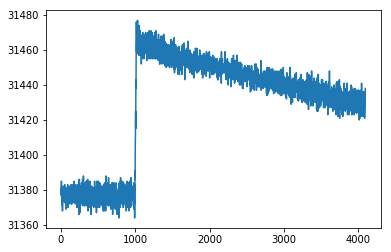

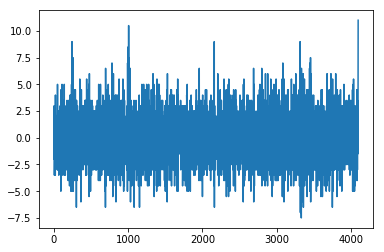

In [2]:
h5file = tables.open_file("cs137_co60.h5", driver="H5FD_CORE")
print(h5file)
data = h5file.root.RawData
EventData = h5file.root.EventData
print(EventData[2])



plt.figure()
plt.plot(data[1,:])
plt.figure()
plt.plot(np.gradient(data[1,:]))
plt.show()

In [3]:
@jit(parallel = True)
def TrapFilter(mysignal,tau):
    GradSignal = np.gradient(mysignal)
    argPeak = np.argmax(GradSignal)
    avgNoise = np.mean(mysignal[0:argPeak-5])
    newSignal = mysignal - avgNoise
#    
#    @jit(parallel = True)
#    def func(x, a, b):
#        return a * np.exp(-b * x)
#
#    popt, pcov = curve_fit(func, range(0,len(newSignal)-argPeak), newSignal[argPeak:])
#    tau = 1/popt[1]
    
    #signalOnly = newSignal[argPeak:]
    signalOnly = newSignal
    m=40
    #k=int((len(signalOnly)-m)/2)
    #k = peaking time
    #m= Gap time (in samples)
    k=100
    M = tau
    Acc1=0.0
    Acc2=0.0
    l =2*k+m
    final = list(range(len(signalOnly)))
    i=0
    zeros = np.zeros(2*k+m)
    extSignalOnly=np.append(zeros,signalOnly)
    while i < len(signalOnly):
        parta = extSignalOnly[i+(2*k+m)] - extSignalOnly[i-k+(2*k+m)]
        partb = extSignalOnly[i-2*k-m+(2*k+m)] - extSignalOnly[i-k-m+(2*k+m)]
        partc = parta + partb
        Acc1 = Acc1+partc
        partd = partc*M+Acc1
        Acc2 = Acc2 + partd
        final[i] = Acc2
        i=i+1
    
    normFinal = np.array(final)/max(final)
    return normFinal

In [11]:
a = np.array([1,2,3; 1,2,3])
b = np.zeros_like(a)
print(b)

SyntaxError: invalid syntax (<ipython-input-11-90870b3f53e1>, line 1)